# Importing Libraries

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow nltk wordcloud textblob gensim


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk import FreqDist
from wordcloud import WordCloud
from collections import Counter
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk import pos_tag, ne_chunk
from textblob import TextBlob

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder

import gensim.downloader as api

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/woozie_31/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/woozie_31/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/woozie_31/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/woozie_31/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/woozie_31/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Basic Data Exploration

In [4]:
# Load the dataset
data = pd.read_csv('McDonald_s_Reviews.csv', encoding='latin1')

In [5]:
data.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [6]:
data.shape

(33396, 10)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


In [8]:
data.describe()

,reviewer_id,latitude,longitude
count,33396.000000,32736.000000,32736.000000
mean,16698.500000,34.442546,-90.647033
std,9640.739131,5.344116,16.594844
min,1.000000,25.790295,-121.995421
25%,8349.750000,28.655350,-97.792874
50%,16698.500000,33.931261,-81.471414
75%,25047.250000,40.727401,-75.399919
max,33396.000000,44.981410,-73.459820


In [9]:
### Checking the Null Values
data.isnull().sum()

reviewer_id        0
store_name         0
category           0
store_address      0
latitude         660
longitude        660
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

In [10]:
# Check for any duplicates
has_duplicates = data.duplicated().any()
print(has_duplicates)

False


# Text Preprocesing

In [11]:
# Clean the 'rating' column to keep only the number
data['rating'] = data['rating'].str.extract(r'(\d+)').astype(int)

In [12]:
data['rating'].head()

0    1
1    4
2    1
3    5
4    1
Name: rating, dtype: int64

In [13]:
###Drop Nan Values
data=data.dropna()

In [14]:
# Drop the specified columns
columns_to_drop = ['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ', 'longitude', 'rating_count', 'review_time']
data = data.drop(columns=columns_to_drop)

In [15]:
data.head()

,review,rating
0,Why does it look like someone spit on my food?...,1
1,It'd McDonalds. It is what it is as far as the...,4
2,Made a mobile order got to the speaker and che...,1
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,"I repeat my order 3 times in the drive thru, a...",1


In [16]:
X = data['review']
y = data['rating']

In [17]:
messages=X.copy()

In [18]:
messages.head()

0    Why does it look like someone spit on my food?...
1    It'd McDonalds. It is what it is as far as the...
2    Made a mobile order got to the speaker and che...
3    My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...
4    I repeat my order 3 times in the drive thru, a...
Name: review, dtype: object

In [19]:
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()
# Define a function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        u"\U0001F700-\U0001F77F"  # Alchemical Symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed Characters
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)

corpus = []
for i in range(len(messages)):
    # Remove emojis
    review = remove_emojis(messages.iloc[i])  # Use .iloc to access rows by position
    # Remove non-alphabetic characters and convert to lowercase
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    # Lemmatization
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)


In [20]:
corpus

['look like someone spit food normal transaction everyone chill polite dont want eat im trying think milky white clear substance food sure coming back',
 'mcdonalds far food atmosphere go staff make difference friendly accommodating always smiling make pleasant experience many fast food place',
 'made mobile order got speaker checked line moving leave otherwise late work never got refund app called said could get money back person stuck system went person next day manager told',
 'mc crispy chicken sandwich customer service quick p',
 'repeat order time drive thru still manage mess suppose large meal double filet fish large fry cheese wrong either need pay close attention order made understand english need work drive thru',
 'work door dash locked u wait long line reason tried beg open door dash refused covid get new job',
 'could give location zero customer service would pulled drive placed simple order order regular hamburg cooky paid pulled window pick told pull space sat sat minute

# Exploratory Data Analysis(EDA)

In [21]:
# Tokenization and Word Frequency Analysis
all_words = ' '.join(corpus)  # Join all reviews into a single string
tokens = word_tokenize(all_words)  # Tokenize into individual words
freq_dist = FreqDist(tokens)  # Calculate frequency distribution

### Count of Ratings

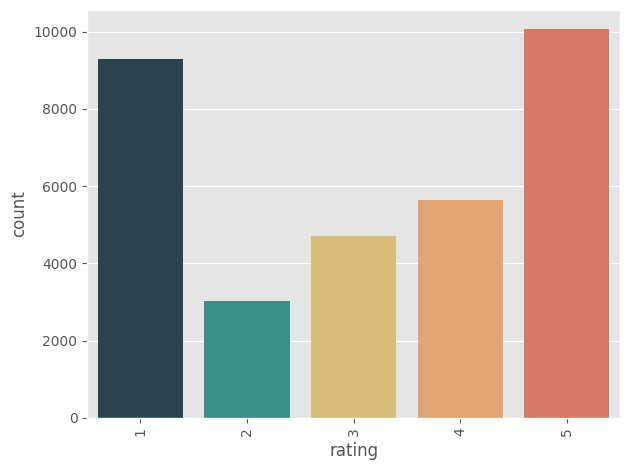

In [22]:
custom_palette = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
ax = sns.countplot(x="rating", data=data, palette=custom_palette)
# Rotate the x-axis labels to 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

### Word Cloud

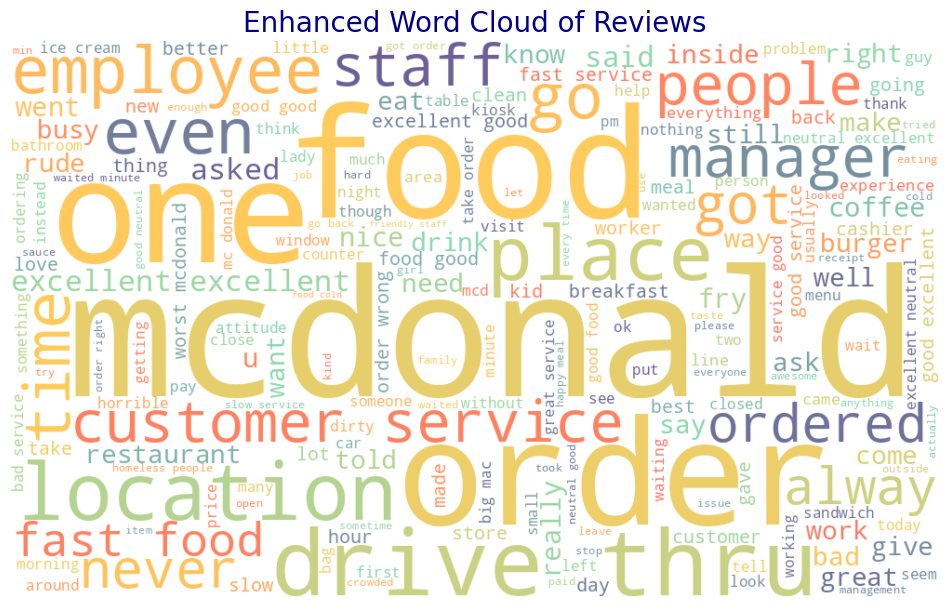

In [23]:
from matplotlib.colors import LinearSegmentedColormap

# Custom color map
colors = LinearSegmentedColormap.from_list("custom_colors", ["#ff6f61", "#ffcc5c", "#88d8b0", "#6b5b95"])

# Generate Word Cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap=colors,
    contour_color='steelblue',
    contour_width=3
).generate(all_words)

# Display Word Cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Enhanced Word Cloud of Reviews', fontsize=20, color='darkblue')
plt.show()

### Word Length Distribution

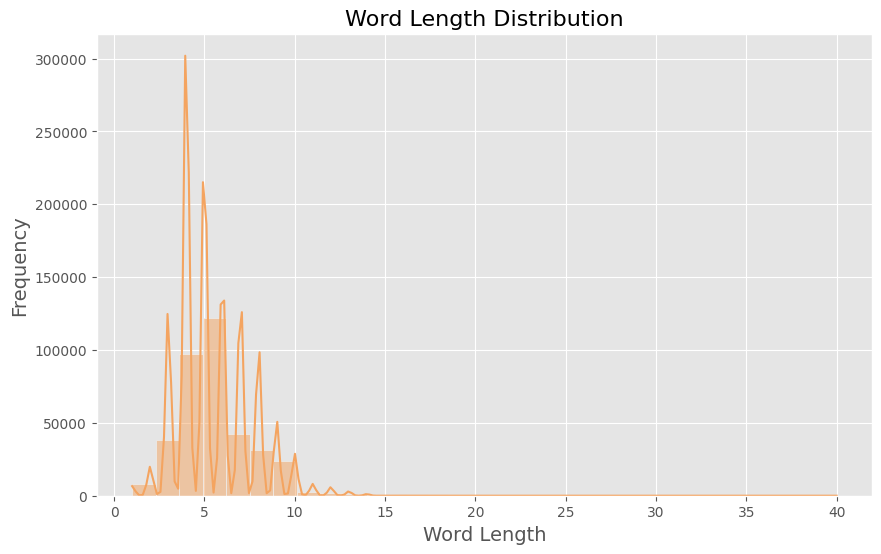

In [24]:
word_lengths = [len(word) for word in tokens]

plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, bins=30, kde=True, color = "sandybrown")
plt.title('Word Length Distribution', fontsize=16)
plt.xlabel('Word Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

plt.show()

### Sentiment Polarity using TextBlob

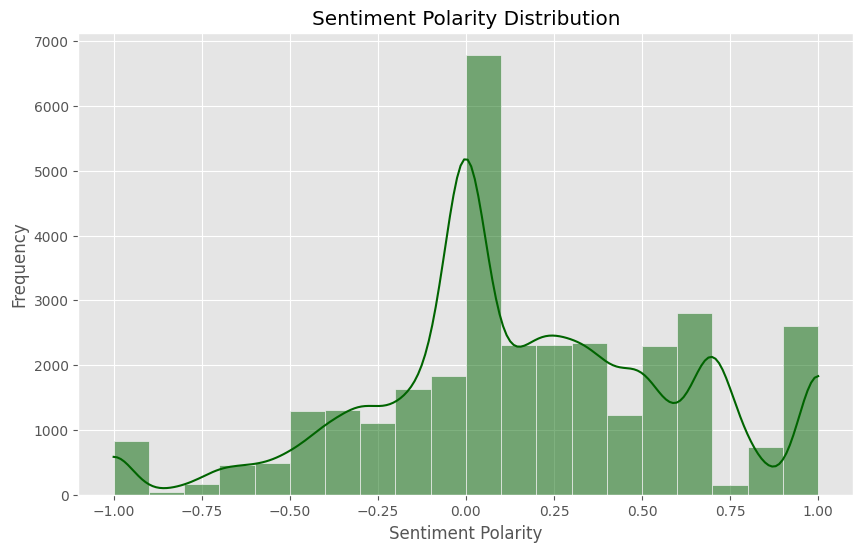

In [25]:
sentiments = [TextBlob(review).sentiment.polarity for review in corpus]

plt.figure(figsize=(10, 6))
sns.histplot(sentiments, bins=20, kde=True, color = "darkgreen")
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

### Analysis of text structure (paragraph lengths) within reviews

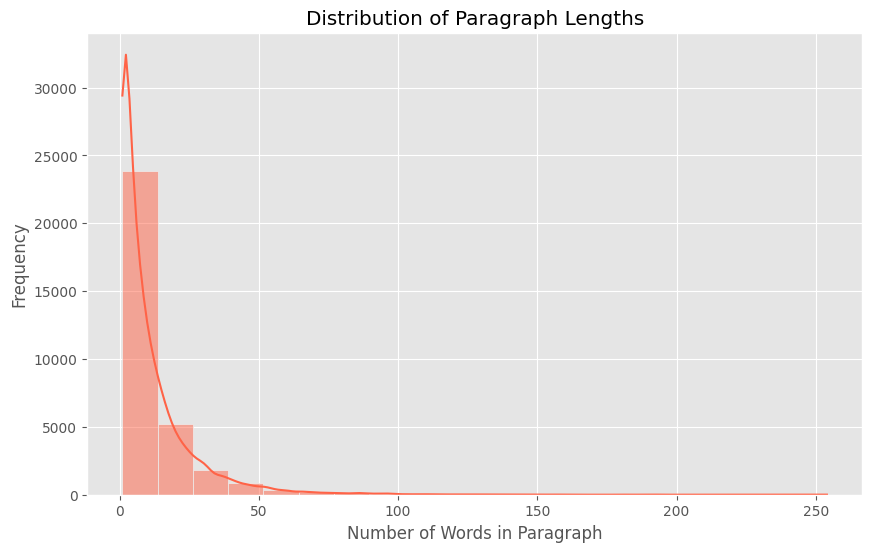

In [26]:
paragraph_lengths = [len(paragraph.split()) for review in corpus for paragraph in review.split('\n') if paragraph.strip()]

plt.figure(figsize=(10, 6))
sns.histplot(paragraph_lengths, bins=20, kde=True, color="tomato")
plt.title('Distribution of Paragraph Lengths')
plt.xlabel('Number of Words in Paragraph')
plt.ylabel('Frequency')
plt.show()

### Unique Words per Review

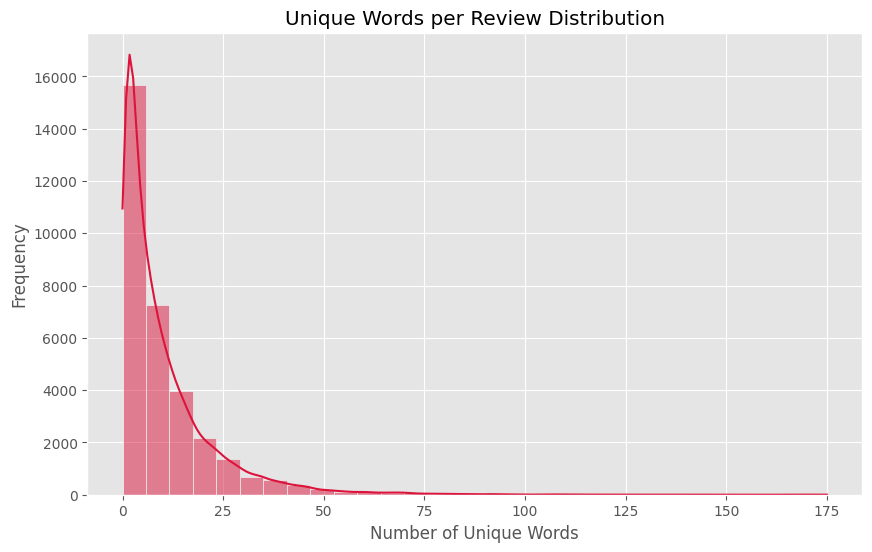

In [27]:
unique_words_per_review = [len(set(review.split())) for review in corpus]

plt.figure(figsize=(10, 6))
sns.histplot(unique_words_per_review, bins=30, kde=True, color="crimson")
plt.title('Unique Words per Review Distribution')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')
plt.show()

### Common Stopwords

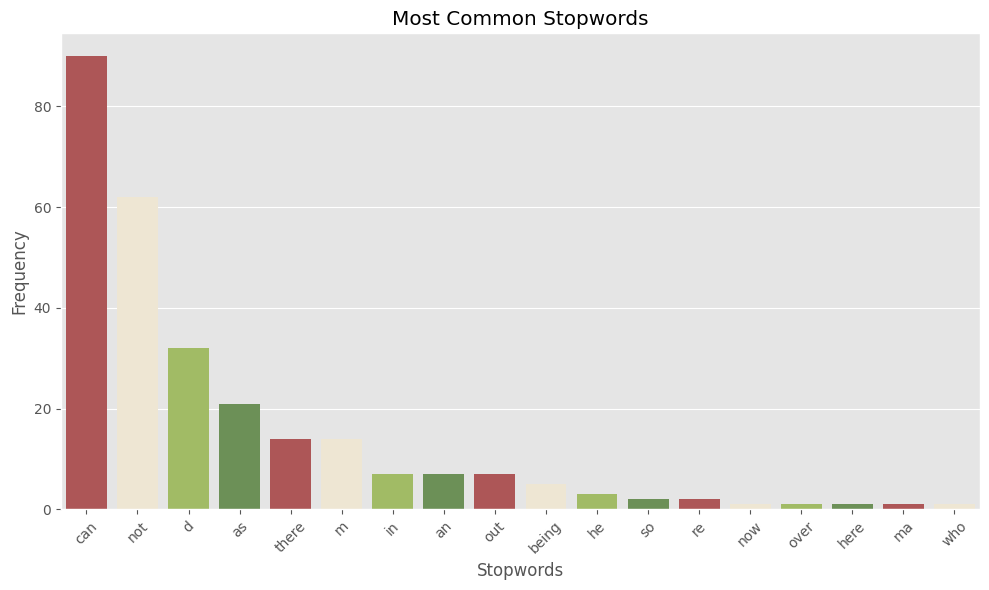

In [28]:
stop_words = set(stopwords.words('english'))
stopword_count = Counter(word for word in tokens if word in stop_words)

custom_palette = ['#bc4749', '#f2e8cf', '#a7c957', '#6a994e']

plt.figure(figsize=(10, 6))
sns.barplot(x=[word for word, _ in stopword_count.most_common(20)],
            y=[count for _, count in stopword_count.most_common(20)],
            palette=custom_palette)
plt.title('Most Common Stopwords')
plt.xlabel('Stopwords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Bigram and Trigram Analysis

In [29]:
bigram_finder = BigramCollocationFinder.from_words(tokens)
trigram_finder = TrigramCollocationFinder.from_words(tokens)

In [30]:
# Top 20 Bigrams
print("\nTop 20 Bigrams:")
print(bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 20))

# Top 20 Trigrams
print("\nTop 20 Trigrams:")
print(trigram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, 20))


Top 20 Bigrams:
[('drive', 'thru'), ('customer', 'service'), ('excellent', 'excellent'), ('ice', 'cream'), ('big', 'mac'), ('fast', 'food'), ('quarter', 'pounder'), ('neutral', 'excellent'), ('excellent', 'neutral'), ('happy', 'meal'), ('mc', 'donald'), ('parking', 'lot'), ('excellent', 'good'), ('homeless', 'people'), ('hash', 'brown'), ('good', 'excellent'), ('play', 'area'), ('order', 'wrong'), ('french', 'fry'), ('chicken', 'nugget')]

Top 20 Trigrams:
[('went', 'drive', 'thru'), ('drive', 'thru', 'line'), ('drive', 'thru', 'drive'), ('sat', 'drive', 'thru'), ('drive', 'thru', 'lane'), ('drive', 'thru', 'minute'), ('minute', 'drive', 'thru'), ('line', 'drive', 'thru'), ('drive', 'thru', 'window'), ('waited', 'drive', 'thru'), ('thru', 'drive', 'thru'), ('car', 'drive', 'thru'), ('go', 'drive', 'thru'), ('drive', 'thru', 'car'), ('drive', 'thru', 'speaker'), ('long', 'drive', 'thru'), ('min', 'drive', 'thru'), ('hour', 'drive', 'thru'), ('wait', 'drive', 'thru'), ('lane', 'drive', 

### POS Tags

In [31]:
# Part-of-Speech (POS) Tagging
pos_tags = pos_tag(tokens)

In [32]:
# Count POS tags
pos_counts = Counter(tag for word, tag in pos_tags)
print("\nPOS Tag Counts:")
print(pos_counts)


POS Tag Counts:
Counter({'NN': 154493, 'JJ': 80316, 'RB': 32436, 'VBD': 23572, 'VBG': 13713, 'VBP': 12170, 'VB': 11547, 'VBN': 8692, 'NNS': 7754, 'IN': 7635, 'CD': 3911, 'MD': 2630, 'JJS': 2555, 'JJR': 1550, 'VBZ': 1355, 'DT': 1251, 'RBR': 991, 'FW': 450, 'RP': 428, 'NNP': 418, 'CC': 372, 'RBS': 127, 'PRP': 107, 'WDT': 86, 'UH': 80, 'WRB': 76, 'TO': 72, 'WP': 43, 'PDT': 12, 'EX': 9, 'WP$': 4, 'PRP$': 2, 'SYM': 2, 'POS': 2, "''": 2, '``': 2})


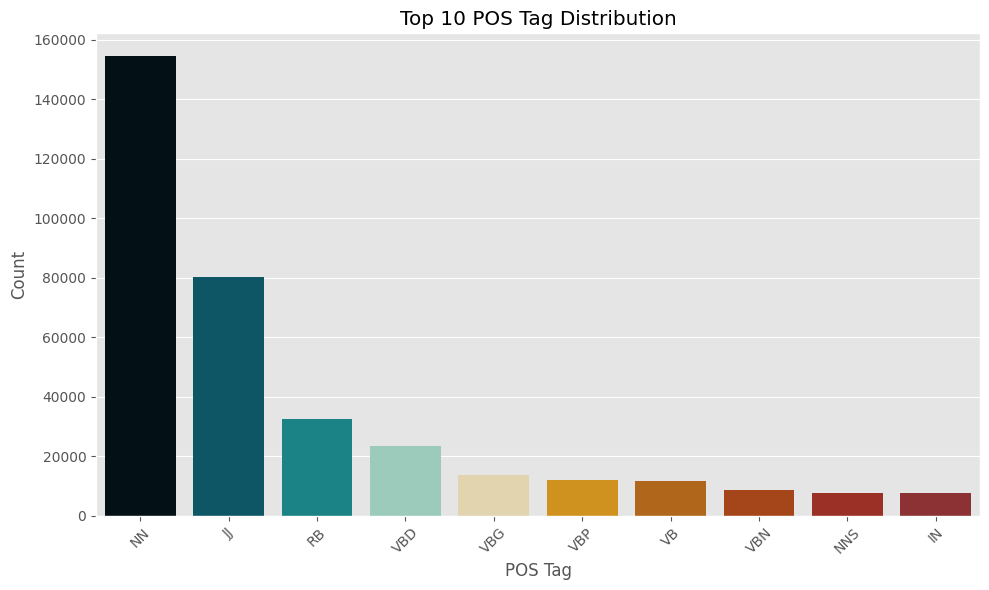

In [33]:
pos_counts_df = pd.DataFrame(pos_counts.items(), columns=['POS Tag', 'Count'])
pos_counts_df = pos_counts_df.sort_values(by='Count', ascending=False).head(10)
custom_palette = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', "#ee9b00", "#ca6702", "#bb3e03", "#ae2012", "#9b2226"]
plt.figure(figsize=(10, 6))
sns.barplot(data=pos_counts_df, x='POS Tag', y='Count', palette=custom_palette)
plt.title('Top 10 POS Tag Distribution')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Lexical Diversity

In [34]:
num_tokens = len(tokens)
num_types = len(set(tokens))
lexical_diversity = num_types / num_tokens
print("\nLexical Diversity (Type-Token Ratio):", lexical_diversity)


Lexical Diversity (Type-Token Ratio): 0.03201713363967847


### Analysis of Textual Entropy

**Computes the Shannon entropy of the corpus to measure the unpredictability or information content of the text**

In [35]:
# Analysis of Textual Entropy (Shannon entropy)
from scipy.stats import entropy
from collections import Counter

# Calculate Shannon entropy for the corpus
word_counts = Counter(all_words)
total_words = sum(word_counts.values())
word_probabilities = [count / total_words for count in word_counts.values()]
entropy_score = entropy(word_probabilities)

print(f"Shannon entropy of the corpus: {entropy_score}")

Shannon entropy of the corpus: 2.9096335161207745


### Analysis of Sentences with Negation

In [36]:
# Example: Identify sentences with negations
sentences_with_negations = [sent for review in corpus for sent in nltk.sent_tokenize(review) if 'not ' in sent]

# Print some examples of sentences with negations
print("Examples of sentences with negations:")
for idx, sent in enumerate(sentences_with_negations[:5]):
    print(f"{idx+1}. {sent}")

Examples of sentences with negations:
1. mmmm honest pretty fast drive order cannot complain run special item frappuccinos pretty fast overall food quality pretty much always fresh
2. almost always use drive thru english first language born new york city said numerous time unable understand person booth cannot understand sometimes faulty intercom issue often someone booth understand speak english properly highly frustrating repeat order much six time yeah said six time last weekend indian kid could life understand could understand polite enough kid reached booth seriously frustrating experience time someone speak language properly close facsimile lol distracted phone finally reach booth pay often usually female lol cashier thumbing phone mcdonald need set standard people work drive thru face face cashier language issue easier deal put people drive intercom way food fine issue end lol work mickey
3. system screen order without speak employee incredible save long line made come language 

### Contextual Word Usage (Concordance)

In [37]:
from nltk.text import Text

# Convert corpus into NLTK Text object
text = Text(tokens)

# Print concordance for a specific word (e.g., 'good')
print("Concordance for 'good':")
text.concordance('good', lines=10)

Concordance for 'good':
Displaying 10 of 5504 matches:
d would recomend location hit pretty good beginning everything great last long
rience review low order order create good business giving people exceptional e
issing meal normally location pretty good last night absolutely ridiculous sat
y get better fast food place anymore good quick drive service long line went q
 service better food hey go kid love good customer service guy make difference
even coming drive take half hour get good lot people behind got food one cared
 pony tail read previous review thry good need check going never would come ba
g hard earned money customer service good staff play game pay money see horsin
ite addressed fry kinda cold another good place get food affordable price alri
m error bit smaller location overall good place grab quick bite near lake cree


# Train Test Split and Creating Word Embeddings

In [38]:
sent_df = pd.DataFrame(corpus, columns=['reviews'])
sent_df['rating'] = data['rating']
sent_df

,reviews,rating
0,look like someone spit food normal transaction...,1.0
1,mcdonalds far food atmosphere go staff make di...,4.0
2,made mobile order got speaker checked line mov...,1.0
3,mc crispy chicken sandwich customer service qu...,5.0
4,repeat order time drive thru still manage mess...,1.0
...,...,...
32731,treated badly,3.0
32732,service good,3.0
32733,remove hunger enough,3.0
32734,good lately become expensive,1.0


from sklearn.model_selection import train_test_split

In [39]:
# Download and load the Google News Word2Vec model
word2vec_model = api.load("word2vec-google-news-300")

In [40]:
# Create a word index mapping for padding
all_tokens = [token for tokens in sent_df['reviews'] for token in tokens]
word_index = {word: i+1 for i, word in enumerate(set(all_tokens))}  # 1 is reserved for padding

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert reviews to sequences of indices
X = sent_df['reviews'].apply(lambda x: [word_index.get(word, 0) for word in x])

# Padding sequences to ensure uniform input size
X = pad_sequences(X, padding='post')

# Define target labels (sentiment)
def categorize_rating(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

sent_df['sentiment'] = sent_df['rating'].apply(categorize_rating)

y = sent_df['sentiment']

2024-12-12 12:33:05.063876: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 12:33:05.072681: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 12:33:05.075927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 12:33:05.083618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733986985.095557  398985 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733986985.09

In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure the embedding dimension is 300 (Google News Word2Vec)
embedding_dim = 300

# Prepare the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Fill the embedding matrix with vectors from the Google News Word2Vec model
for word, i in word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        # If the word is not found in the Word2Vec model, leave it as a zero vector
        continue

# BiLSTM Model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),  # Make sure the embeddings are non-trainable
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: Positive, Neutral, Negative
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary to check if everything looks good
model.summary()

W0000 00:00:1733986987.948530  398985 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,400 (32.81 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,400 (32.81 KB)

In [44]:
# Train the model and save the training history
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.5243 - loss: 0.9511 - val_accuracy: 0.6016 - val_loss: 0.8619
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.6004 - loss: 0.8674 - val_accuracy: 0.5900 - val_loss: 0.8704
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6050 - loss: 0.8616 - val_accuracy: 0.6116 - val_loss: 0.8501
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.6121 - loss: 0.8549 - val_accuracy: 0.6147 - val_loss: 0.8492
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.6155 - loss: 0.8509 - val_accuracy: 0.6193 - val_loss: 0.8451
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6247 - loss: 0.8399 - val_accuracy: 0.6257 - val_loss: 0.8394
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6346 - loss: 0.8308 - val_accuracy: 0.6332 - val_loss: 0.8320
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6359 - loss: 0.8274 - val_accu

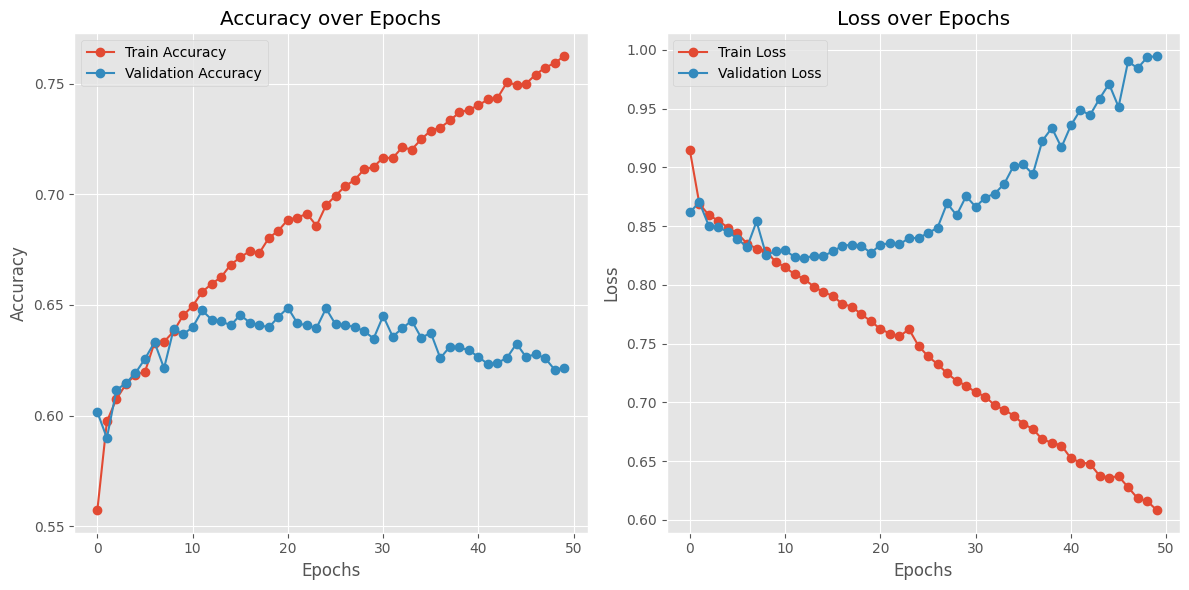

In [45]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [46]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

205/205 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

Confusion Matrix:
[[1673  135  720]
 [ 315  218  373]
 [ 777  158 2179]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.61      0.66      0.63      2528
     Neutral       0.43      0.24      0.31       906
    Positive       0.67      0.70      0.68      3114

    accuracy                           0.62      6548
   macro avg       0.57      0.53      0.54      6548
weighted avg       0.61      0.62      0.61      6548



In [49]:
def preprocess_text(text):
    # Tokenizing and removing non-alphanumeric characters
    tokens = word_tokenize(text.lower())
    return tokens

# Test the model with a custom sentence
def predict_sentiment(sentence):
    tokens = preprocess_text(sentence)
    sequence = [word_index.get(word, 0) for word in tokens]
    sequence = pad_sequences([sequence], padding='post', maxlen=X.shape[1])
    pred = model.predict(sequence)
    return ['Negative', 'Neutral', 'Positive'][np.argmax(pred)]

# Test with a specific sentence
test_sentence = "I really enjoyed the meal today!"
print("\nPredicted Sentiment for the sentence:")
print(predict_sentiment(test_sentence))


Predicted Sentiment for the sentence:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Positive
